In [1]:
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect
import os 
if not os.path.exists('figures'):
    os.makedirs('figures')

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
!nvidia-smi

Wed May  1 11:26:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   26C    P0              48W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def tf_2(etas, ws, lamb):
  return jnp.sum((ws**2) * etas**2/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return x

def solve_kappa2(P, Ns:list, lamb, etaX, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1(etaX, kappa)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1(etaX, kappa)
    return newton(fn, x0=0.0, **kwargs)
  
  def fn_lamb(kappa, lamb):
    ans = kappa * (1 - D/P * df_1(etaX, kappa))
    for N in Ns[1:]:
      ans *= N/D - df_1(etaX, kappa)
    return ans - lamb
  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: fn_lamb(kappa, anneal_lamb)
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next: 
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  print("Newton didn't converge")
  return kappa

def kappa_inv(etas, df, **kwargs):
  fn = lambda kappa: df_1(etas, kappa) - df
  return newton(fn, x0=0.0, **kwargs)

def solve_kappa2_structured(P, Ns:list, lamb, etaX, etasF, upper_bound=None, anneal_steps=1, **kwargs):
  if not upper_bound:
    upper_bound = lamb + 1e3
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1(etaX, kappa)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1(etaX, kappa)
    return newton(fn, x0=0.0, **kwargs)
  
  def fn_lamb(kappa, lamb):
    ans = kappa * (1 - D/P * df_1(etaX, kappa))
    df1 = df_1(etaX, kappa)
    for N, etaF in zip(Ns[1:], etasF):
      ans *= df1 * approx_fn(df1 * D/N, etaF, N)
    return ans - lamb
  anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
  kappa = upper_bound
  for anneal_lamb in anneal_schedule:
    fn = lambda kappa: fn_lamb(kappa, anneal_lamb)
    kappa_next = newton(fn, x0=kappa, **kwargs)
    if not kappa_next: 
      print("Annealing didn't find kappa. Returning last value.")
      return kappa
    kappa = kappa_next
  return kappa

def estimate_df1_kappa1(lamb, X_tr, FX_tr):
  P, D = X_tr.shape
  N = FX_tr.shape[1]
  q = D/P
  if q >= 1:
    gram = FX_tr @ FX_tr.T / P
    df1 = jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)) @ gram)/D
    kappa1 = (jnp.trace(jnp.linalg.inv(gram + lamb*np.identity(P)))/P)**(-1)
    return df1, kappa1
    
  else:
    cov = FX_tr.T @ FX_tr / P
    df1 = jnp.trace(jnp.linalg.inv(cov + lamb*np.identity(N)) @ cov)/D
    kappa1 = lamb/(1-q * df1)
    return df1, kappa1
  
def get_spaced_colors(cmap_name, k):
    cmap = plt.cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, k))
    return colors


In [3]:
def simulate_theory(Ns, qs, lambs, sigma_epsilon, X_spec, F_specs, teacher, X_te, y_te, num_X_seeds, num_F_seeds, verbose=True):
    if type(lambs) not in [list, np.ndarray]:
        lambs = [lambs]*len(qs)
    lambs = np.array(lambs)
    data = {}
    L = len(Ns)
    D = Ns[0]
    N = Ns[-1]
    Ss = [jnp.diag(X_spec)]
    if not F_specs:
        F_specs = [jnp.ones(N) for N in Ns[1:]]
    for F_spec in F_specs:
        Ss.append(jnp.diag(F_spec))        
    w = teacher
    for i in tqdm(range(len(qs)), disable=not verbose):
        q, lamb  = qs[i], lambs[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        df1_empirical = np.zeros((num_X_seeds, num_F_seeds))
        kappa_GCV = np.zeros((num_X_seeds, num_F_seeds))
        Etrs = np.zeros((num_X_seeds, num_F_seeds))
        s_vals = {}
        for X_seed in range(num_X_seeds):
            X_key = random.PRNGKey(X_seed)
            X_tr_key, e_key= random.split(X_key)
            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(Ss[0])
            y_tr = X_tr @ w + epsilon
            y_tr_clean = X_tr @ w

            for F_seed in range(num_F_seeds):
                F_key = random.PRNGKey(F_seed)
                F_keys = random.split(F_key, L)
                F = jnp.identity(D)
                for l in range(1, L):
                    F_l = random.normal(F_keys[l], (Ns[l-1], Ns[l])) @ jnp.sqrt(Ss[l])/np.sqrt(Ns[l-1])
                    F = F @ F_l
                FX_tr = X_tr @ F
                FX_te = X_te @ F
                
                if lamb == 0:
                    soln = jnp.linalg.lstsq(FX_tr, y_tr, rcond=None)
                    w_star, s_val = soln[0], soln[-1]
                    w_star_clean = jnp.linalg.lstsq(FX_tr, y_tr_clean, rcond=None)[0]
                    y_hat_tr = FX_tr @ w_star
                    Etrs[X_seed, F_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                    s_vals[(X_seed, F_seed)] = s_val
                elif P > N:
                    cov = FX_tr.T @ FX_tr / P
                    w_star = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr / P)
                    w_star_clean = jnp.linalg.solve(cov + lamb*np.identity(N), FX_tr.T @ y_tr_clean / P)
                    y_hat_tr = FX_tr @ w_star
                    Etrs[X_seed, F_seed] = jnp.mean((y_tr - y_hat_tr)**2)
                else: 
                    gram = FX_tr @ FX_tr.T / P
                    w_star = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr) / P
                    w_star_clean = FX_tr.T @ jnp.linalg.solve(gram + lamb*np.identity(P), y_tr_clean) / P
                    Etrs[X_seed, F_seed] = lamb**2/P * jnp.sum((jnp.linalg.solve(gram + lamb*np.identity(P),  y_tr))**2)

                y_hats[X_seed, F_seed, :] = FX_te @ w_star
                y_hats_clean[X_seed, F_seed, :] = FX_te @ w_star_clean
                    
                df1_emp, kappa1_emp = estimate_df1_kappa1(lamb, X_tr, FX_tr)
                df1_empirical[X_seed, F_seed] = df1_emp
                kappa_GCV[X_seed, F_seed] = kappa1_emp

        Eg = np.mean((y_hats - y_te[None, None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias =  np.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2)
        VarX = np.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2, axis=-1) - Bias
        VarF = np.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2, axis=-1) - Bias
        VarXF =  Signal - VarX - VarF - Bias
        VarXe = jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2, axis=-1)
        VarXFe = Noise - VarXe
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': np.mean(Noise),
            'Noise_std': np.std(Noise),
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarF': np.mean(VarF),
            'VarF_std': np.std(VarF),
            'VarXF': np.mean(VarXF),
            'VarXF_std': np.std(VarXF),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'VarXFe': np.mean(VarXFe),
            'VarXFe_std': np.std(VarXFe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
        if lamb == 0:
            data[q]['s_vals'] = s_vals

    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT
    

def solve_theory(Ns, qs, lambs, sigma_epsilon, X_spec, F_spec, teacher, anneal_steps=0, **kwargs):
    if type(lambs) not in [list, np.ndarray]:
        lambs = [lambs]*len(qs)
    lambs = np.array(lambs)
    D = Ns[0]
    if F_spec:
        kappa2 = jnp.array([
            solve_kappa2_structured(D/q, Ns, lamb=lamb, etaX=X_spec, etasF=F_spec, anneal_steps=anneal_steps, **kwargs)
            for lamb, q in zip(lambs, qs)])
    else:
        kappa2 = jnp.array([
            solve_kappa2(D/q, Ns, lamb=lamb, etaX=X_spec, anneal_steps=anneal_steps, **kwargs)
            for lamb, q in zip(lambs, qs)])
    df1k2 = jnp.array([df_1(X_spec, k) for k in kappa2])
    df2k2 = jnp.array([df_2(X_spec, k) for k in kappa2])
    tf1pk2 = jnp.array([tf_1p(X_spec, teacher, k) for k in kappa2])
    tf1k2 = jnp.array([tf_1(X_spec, teacher, k) for k in kappa2])
    tf2k2 = jnp.array([tf_2(X_spec, teacher, k) for k in kappa2])
    gamma2 = qs * df2k2
    kappa1 = kappa2
    for N in Ns[1:]:
        kappa1 *= (N/D - df1k2)
    dlogS = 0
    for N in Ns[1:]:
        dlogS += df1k2/(N/D - df1k2)
    dlogk1k2 = 1 + (df1k2-df2k2)/df1k2 * dlogS
    dlogk2k1 = 1/dlogk1k2
    gamma1 = qs * df1k2 * (1 - (df1k2 - df2k2)/df1k2 * dlogk2k1)
    
    signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
    noise = sigma_epsilon**2 * gamma1/(1-gamma1)
    bias = kappa2**2 * tf1pk2
    varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
    varXe = sigma_epsilon**2 * gamma2/(1-gamma2)
    varXFe = noise - varXe
    varF = (1 - dlogk2k1) * kappa2 * tf2k2
    varXF = signal - varX - varF - bias
    Eg = signal + noise
    Etr = ((lambs/kappa1)**2)*(Eg + sigma_epsilon**2)
    data = {
        'kappa2': kappa2,
        'kappa1': kappa1,
        'df1k2': df1k2,
        'df2k2': df2k2,
        'tf1pk2': tf1pk2,
        'tf1k2': tf1k2,
        'tf2k2': tf2k2,
        'dlogS': dlogS,
        'dlogk2k1': dlogk2k1,
        'dlogk1k2': dlogk1k2,
        'gamma1': gamma1,
        'gamma2': gamma2,
        'Bias': bias,
        'VarX': varX,
        'VarF': varF,
        'VarXF': varXF,
        'VarXe': varXe,
        'VarXFe': varXFe,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

In [4]:
expts = {}

In [5]:
p = 10
D = 10_000

qs = np.logspace(0, 3, 20)
qs2 = qs
qs = qs[2:]
ps = D/qs
ps2 = D/qs2
P_te = 200
sigma_epsilon = 0.


num_F_seeds = 10
num_X_seeds = 10

lamb = 0
alpha0 = 1.7
r = 0.8


SX = jnp.diag(jnp.arange(1, D+1)**(-alpha0))
w = jnp.arange(1, D+1)**(-(1 + alpha0 * (2*r - 1))/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w



widths = np.logspace(2, 4, 10, dtype=int)
alpha_ls = [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5]
for alpha_l in alpha_ls:
    alphas = [alpha0, alpha_l]
    for N in tqdm(widths):
        Ns = [D, N]
        all_etas= [jnp.arange(1, N+1)**(-alpha) for alpha, N in zip(alphas, Ns)]
        Ss = [jnp.diag(etas) for etas in all_etas]
        SX = Ss[0]

        expts[(alpha_l, N)] = simulate_theory(Ns, [D/p], lamb, sigma_epsilon, all_etas[0], all_etas[1:], w, X_te, y_te, num_X_seeds, num_F_seeds, verbose=False)
    

100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


/tmp/ipykernel_643196/111043236.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


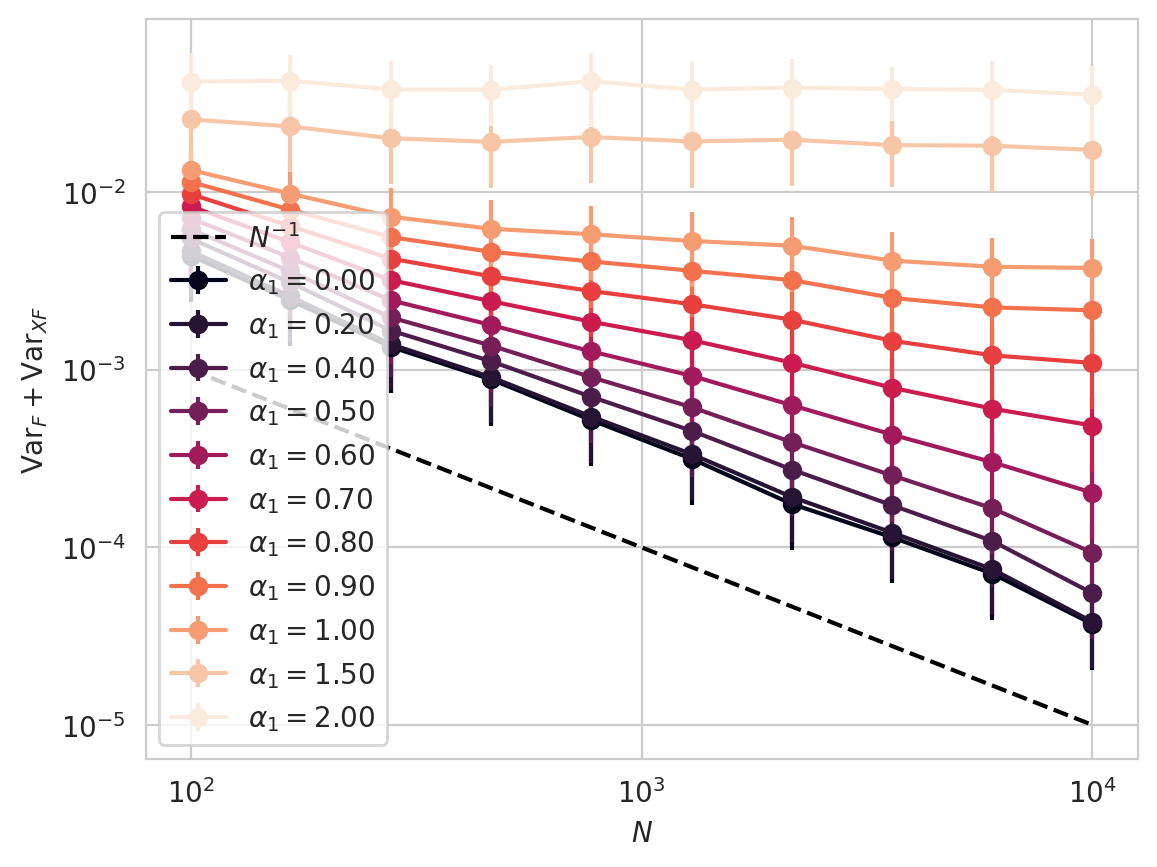

In [10]:
colors = get_spaced_colors('rocket', 11)
for i, alpha_l in enumerate([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]):
    errs = np.array([expts[(alpha_l, N)]['VarF']+expts[(alpha_l, N)]['VarXF'] for N in widths]).flatten()
    stds = np.array([expts[(alpha_l, N)]['VarF_std']+expts[(alpha_l, N)]['VarXF_std'] for N in widths]).flatten()
    stds = np.minimum(stds, errs*0.9)/2
    plt.errorbar(widths, errs, stds, label=f"$\\alpha_1=${alpha_l:.2f}", marker='o', color=colors[i])
plt.loglog(widths, 1e-1*np.array(widths, float)**(-1), 'k--', label='$N^{-1}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\\mathrm{{Var}}_F + \\mathrm{{Var}}_{{XF}}$')
plt.legend()
# plt.savefig('figures/structured_covariates_lrf_varF_vs_N.pdf', bbox_inches='tight')


/tmp/ipykernel_274500/111043236.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)


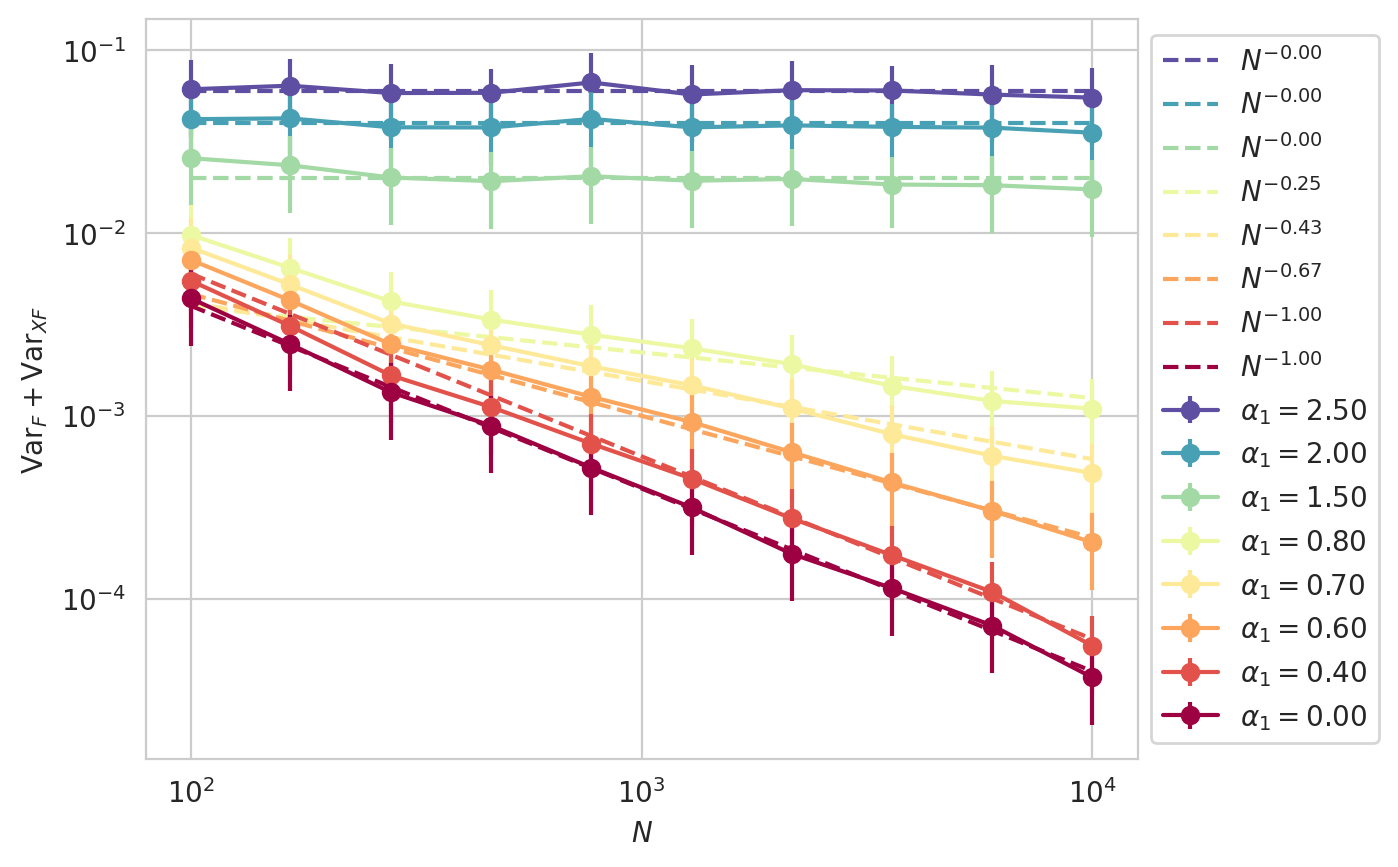

In [20]:
colors = get_spaced_colors('Spectral', 8)[::-1]
coeffs = [4e-1, 6e-1, 1e-1, 3e-2, 1.25e-2, 2e-2, 4e-2, 6e-2][::-1]
for i, alpha_l in enumerate([0.0, 0.4, 0.6, 0.7, 0.8, 1.5, 2.0, 2.5][::-1]):
    # if alpha_l in [0.2, 0.7, 0.9, 1.0]: continue
    c = 0.0 if alpha_l > 1.0 else (1 if alpha_l < 0.5 else (1-alpha_l)/alpha_l)
    errs = np.array([expts[(alpha_l, N)]['VarF']+expts[(alpha_l, N)]['VarXF'] for N in widths]).flatten()
    stds = np.array([expts[(alpha_l, N)]['VarF_std']+expts[(alpha_l, N)]['VarXF_std'] for N in widths]).flatten()
    stds = np.minimum(stds, errs*0.9)/2
    plt.errorbar(widths, errs, stds, label=f"$\\alpha_1=${alpha_l:.2f}", marker='o', c=colors[i])
    plt.plot(widths, coeffs[i]* np.array(widths, float)**(-c), '--', label=f'$N^{{-{c:.2f}}}$', c=colors[i])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N$')
plt.ylabel('$\\mathrm{{Var}}_F + \\mathrm{{Var}}_{{XF}}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/all_structured_covariates_lrf_varF_nontrivial_scaling2.pdf', bbox_inches='tight')


Text(0, 0.5, 'Singular Value')

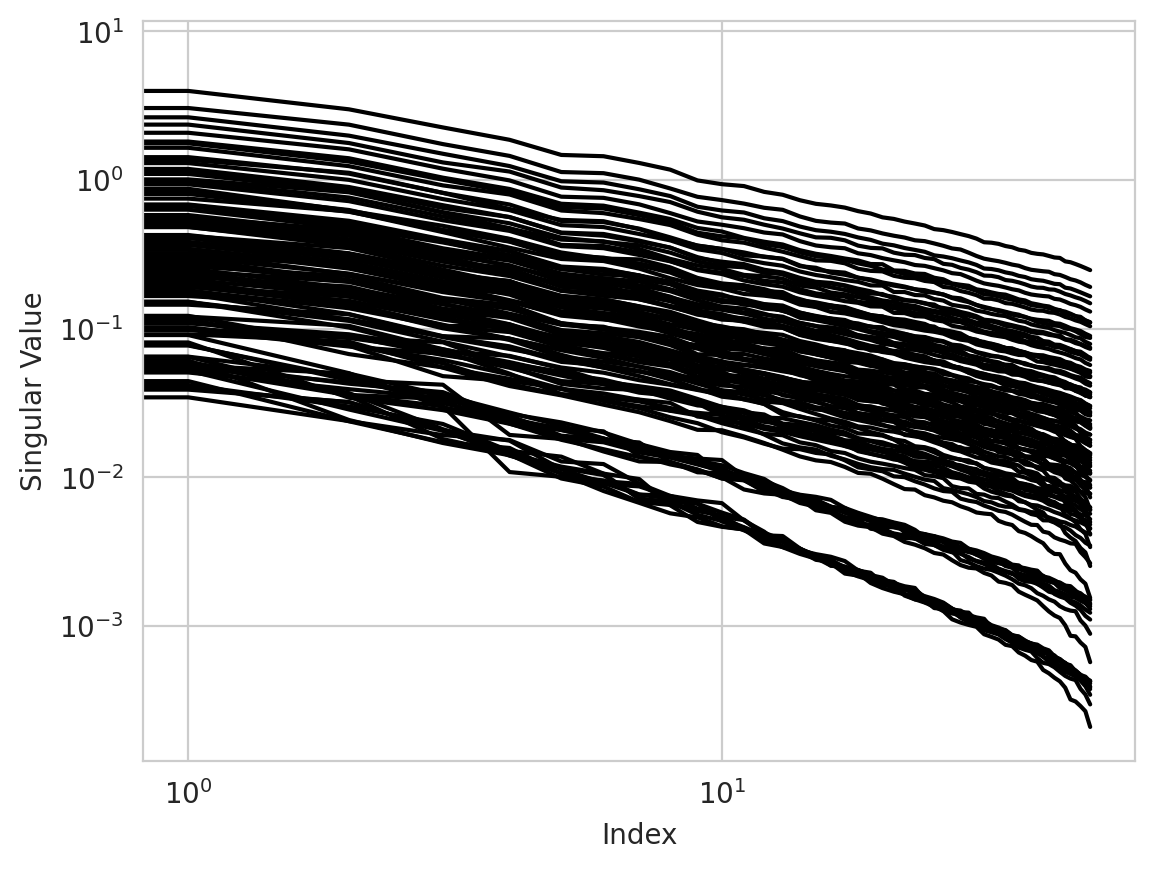

In [114]:
for alpha_l in alpha_ls:
    for N in widths:
        plt.loglog(expts[(alpha_l, N)]['s_vals'][0][0, 0], 'k')
plt.xlabel('Index')
plt.ylabel('Singular Value')